In [163]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
from dateutil.parser import parse
import matplotlib.pyplot as plt
import seaborn as sns
import json
import boto3
import io
from scipy import signal
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
%matplotlib inline 

In [4]:
conn = boto3.client('s3')
s3 = boto3.resource('s3')

In [44]:
data = []
tag = []
for item in conn.list_objects(Bucket='aads-tagyourmeal')['Contents']:
    filename = item['Key']
    if 'motion' in filename:
        print(filename)
        obj = conn.get_object(Bucket='aads-tagyourmeal',Key=filename)
        motion_df = pd.read_csv(f"s3://aads-tagyourmeal/{filename}",header=None, sep=",")
        userid, datatype, timestamp = filename.split('.')[0].split('_')
        print(userid, datatype, timestamp)
    if 'event' in filename:
        print(filename)
        obj = conn.get_object(Bucket='aads-tagyourmeal',Key=filename)
        event_df = pd.read_csv(f"s3://aads-tagyourmeal/{filename}",header=None,sep=':\ ')
        userid, datatype, timestamp = filename.split('.')[0].split('_')
        print(userid, datatype, timestamp)


alpha_event_2019-02-28 13:42:33 +0000.txt
alpha event 2019-02-28 13:42:33 +0000
alpha_motiondata_2019-02-28 13:42:33 +0000.txt


/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/ipykernel/__main__.py:14: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.


alpha motiondata 2019-02-28 13:42:33 +0000


In [138]:
event_df

,0,1
0,2019-02-28 13:42:33 +0000,session started
1,2019-02-28 16:48:37 +0000,meal started
2,2019-02-28 16:57:01 +0000,meal completed
3,2019-02-28 16:57:03 +0000,utensil used is 4
4,2019-02-28 17:14:52 +0000,session completed
5,2019-02-28 17:14:52 +0000,session completed


In [141]:
motion_df.head(10)

,0,1,2,3,4,5,6,ts
0,1,-0.014318,0.004217,-0.009334,0.070907,-0.006055,0.051615,5.060553e+06
1,2,0.006880,-0.044326,-0.021266,-0.033716,-0.013933,0.073880,5.060553e+06
2,3,-0.008435,-0.016091,-0.002174,-0.056349,-0.030362,0.026274,5.060553e+06
3,4,-0.021171,0.020079,0.003601,0.052620,-0.017035,0.017771,5.060553e+06
4,5,-0.001940,-0.011922,0.003972,0.072882,-0.008274,0.035636,5.060553e+06
5,6,-0.006122,-0.020728,0.000828,-0.026528,-0.018321,0.048292,5.060553e+06
6,7,-0.006394,-0.008450,0.022400,-0.047896,-0.015310,0.030355,5.060553e+06
7,8,-0.004547,0.011015,0.036326,0.049404,-0.007414,0.017734,5.060553e+06
8,9,-0.015933,0.025445,0.022979,0.157265,0.041290,0.018577,5.060553e+06
9,10,-0.004722,-0.016904,0.031717,0.170936,0.073491,0.021426,5.060553e+06


In [139]:
mealstartts = parse(event_df[event_df[1]=='meal started'].iloc[0,0]) 
mstart = (mealstartts - baseline_date).total_seconds()
mealendts = parse(event_df[event_df[1]=='meal completed'].iloc[0,0]) 
mend = (mealendts - baseline_date).total_seconds()
print(mstart,mend)

5071717.0 5072221.0


In [195]:
motion_df.loc[(motion_df['ts']<mstart) & (motion_df['ts']>mend), "tag"] = 0
motion_df.loc[(motion_df['ts']>=mstart) & (motion_df['ts']<=mend), "tag"] = 1
motion_df["ACC"] = (motion_df[3]*motion_df[3] + motion_df[1]*motion_df[1] + motion_df[2]*motion_df[2])
motion_df["ACC_Mean"] = (motion_df[1] + motion_df[2] + motion_df[3])/3
motion_df["ACC_Max"] = motion_df[[1,2,3]].max(axis=1)

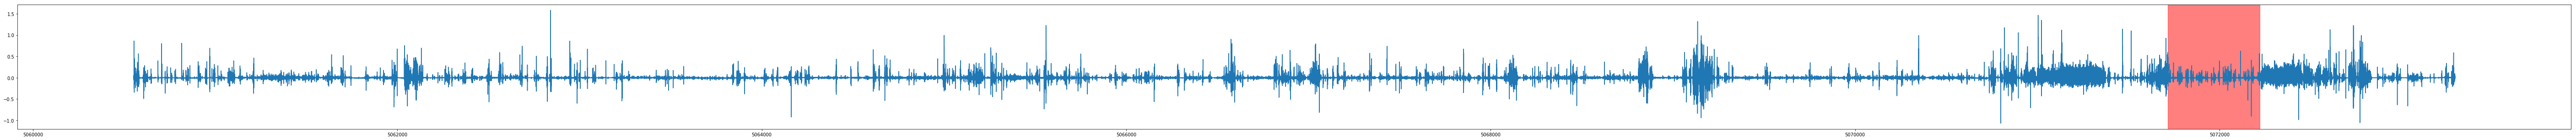

In [303]:
fig=plt.figure(figsize=(100,5))
plt.plot(motion_df['ts'], motion_df["ACC_Mean"])
plt.axvspan(mstart,mend,color="red",alpha=0.5)
# motion_df[(motion_df['ts']>mstart) & (motion_df['ts']<mend)]

# First 100 s Power Density of Mean Accelerometer

[<matplotlib.lines.Line2D at 0x7fe6742ae550>]

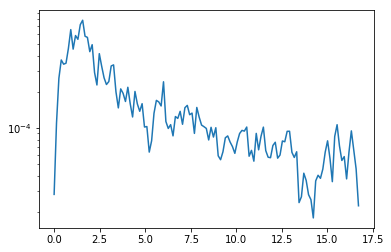

In [304]:
f, Pxx_den = signal.welch(motion_df["ACC_Mean"][0:3342],33.42)
plt.semilogy(f, Pxx_den)


# Feature Engineering, using Welch's method to estimate the power spectural density

In [305]:
features = []
tags = []
for i in range(len(motion_df) // 3342):
    chunk = motion_df.iloc[i*3342:(i+1)*3342,:]
    _, Pxx_den_x = signal.welch(chunk[1],33.42)
    _, Pxx_den_y = signal.welch(chunk[2],33.42)
    _, Pxx_den_z = signal.welch(chunk[3],33.42)
    feature = np.append(Pxx_den_x,Pxx_den_y)
    feature = np.append(feature, Pxx_den_z)
    features.append(feature)
    tags.append(chunk['tag'].mean())

In [306]:
X=np.asarray(features)
y=np.asarray(tags)

# Visulization of the features
## PCA



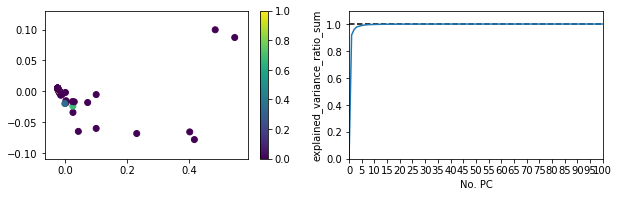

In [297]:
nc = 100

pca = PCA(n_components=nc)
principalComponents = pca.fit_transform(X)

principalDf = pd.DataFrame(data = principalComponents[:,0:2], columns = ['principal component 1', 'principal component 2'])
finalDF = pd.concat([principalDf, pd.DataFrame(tags)], axis = 1)
fig = plt.figure(figsize=(10,6))
fig.add_axes()
ax1 = fig.add_subplot(221)
sc = plt.scatter(x="PC1",
                 y="PC2",
                 data=pd.DataFrame(data = principalComponents[:,0:2], columns = ['PC1', 'PC2']),
                 c=tags,
                 cmap='viridis')
plt.colorbar(sc)


pcaratio=pca.explained_variance_ratio_
s = 0
s_list=[0]
for r in pcaratio:
    s+=r
    s_list.append(s)

ax2 = fig.add_subplot(222)
ax2.plot(s_list)
ax2.hlines(s_list[-1],0,nc,linestyles='dashed')
ax2.axis([0,nc,0,1.1])
plt.xticks(np.arange(0,nc+1,step=5))
plt.ylabel('explained_variance_ratio_sum')
plt.xlabel('No. PC')
plt.show()


## Using t-SNE

[t-SNE] Computing 16 nearest neighbors...
[t-SNE] Indexed 127 samples in 0.000s...
[t-SNE] Computed neighbors for 127 samples in 0.004s...
[t-SNE] Computed conditional probabilities for sample 127 / 127
[t-SNE] Mean sigma: 0.000527
[t-SNE] KL divergence after 250 iterations with early exaggeration: 55.867916
[t-SNE] Error after 1000 iterations: 0.525929
[t-SNE] Computing 16 nearest neighbors...
[t-SNE] Indexed 127 samples in 0.000s...
[t-SNE] Computed neighbors for 127 samples in 0.004s...
[t-SNE] Computed conditional probabilities for sample 127 / 127
[t-SNE] Mean sigma: 0.009859
[t-SNE] KL divergence after 250 iterations with early exaggeration: 52.927742
[t-SNE] Error after 1000 iterations: 0.395158


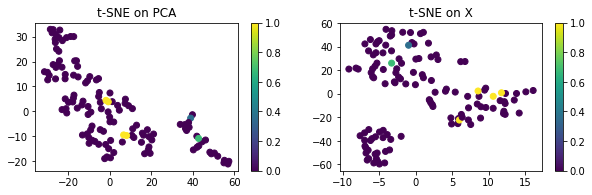

In [302]:
from sklearn.manifold import TSNE
lr = 10
pp = 5

X_tsne_pca = TSNE(learning_rate=lr,
                  n_components=2, 
                  perplexity=pp, 
                  verbose=1, 
                  n_iter=1000).fit_transform(principalComponents)

X_tsne = TSNE(learning_rate=lr,
              n_components=2, 
              perplexity=pp, 
              verbose=1, 
              n_iter=1000).fit_transform(x)

fig = plt.figure(figsize=(10,6))
fig.add_axes()
ax1 = fig.add_subplot(221)
ax1.set(title="t-SNE on PCA")
sc = plt.scatter(x="PC1",
                 y="PC2",
                 data=pd.DataFrame(data = X_tsne_pca[:,0:2], columns = ['PC1', 'PC2']),
                 c=tags,
                 cmap='viridis')
plt.colorbar(sc)

ax2 = fig.add_subplot(222)
ax2.set(title="t-SNE on X")
sc = plt.scatter(x="PC1",
                 y="PC2",
                 data=pd.DataFrame(data = X_tsne[:,0:2], columns = ['PC1', 'PC2']),
                 c=tags,
                 cmap='viridis')
plt.colorbar(sc)

In [307]:
!git commit -m "add sensor data"

On branch master
Your branch is up-to-date with 'origin/master'.

Changes not staged for commit:
	modified:   survey_data_lookup.ipynb

Untracked files:
	package_install.ipynb
	sensor_data_lookup.ipynb

no changes added to commit
